In [4]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
import pandas as pd
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.layers import LSTM
import plotly.offline as py
import plotly.graph_objs as go
import numpy as np
import seaborn as sns
from keras.optimizers import RMSprop, Adam, SGD, Nadam
from keras import backend as K
from keras.layers import Dense, LSTM, TimeDistributed
py.init_notebook_mode(connected=True)
%matplotlib inline

Using TensorFlow backend.


In [5]:
data = pd.read_csv(filepath_or_buffer="./Data/clean_data.csv", index_col="date")

In [6]:
data = data.apply(pd.to_numeric, errors = "coerce")
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7931 entries, 19870520 to 20181102
Data columns (total 8 columns):
TCMNOM_Y2           7931 non-null float64
TCMNOM_Y10          7931 non-null float64
DCOILBRENTEU        7858 non-null float64
spindx              7931 non-null float64
GOLDPMGBD228NLBM    7734 non-null float64
exalus              7931 non-null float64
exjpus              7931 non-null float64
exukus              7931 non-null float64
dtypes: float64(8)
memory usage: 557.6 KB


In [7]:
data['spindx'].replace(0, np.nan, inplace=True)
data['spindx'].fillna(method='ffill', inplace=True)

In [8]:
#reshaping prediction value into value range -1 to 1
from sklearn.preprocessing import MinMaxScaler

# MULTIVARIATE PREDICTION (WITH LOOKBACK AND TIMESTEPS)

In [9]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [10]:
data.columns

Index(['TCMNOM_Y2', 'TCMNOM_Y10', 'DCOILBRENTEU', 'spindx', 'GOLDPMGBD228NLBM',
       'exalus', 'exjpus', 'exukus'],
      dtype='object')

In [11]:
number_of_variables = 8
values = data[['spindx'] + ['TCMNOM_Y2'] + ['TCMNOM_Y10'] + ['DCOILBRENTEU'] + ['GOLDPMGBD228NLBM'] + ['exalus'] + ['exjpus'] + ['exukus']].values
values = values.astype('float32')

In [12]:
look_back = 10
time_steps = 10
series_to_supervised(values, look_back, time_steps)
reframed = series_to_supervised(values, look_back, time_steps)
reframed.tail()

,var1(t-10),var2(t-10),var3(t-10),var4(t-10),var5(t-10),var6(t-10),var7(t-10),var8(t-10),var1(t-9),var2(t-9),...,var7(t+8),var8(t+8),var1(t+9),var2(t+9),var3(t+9),var4(t+9),var5(t+9),var6(t+9),var7(t+9),var8(t+9)
7917,2923.429932,2.82,3.05,85.629997,1204.699951,1.3891,113.660004,0.7702,2925.510010,2.85,...,111.650002,0.7797,2641.250000,2.81,3.08,77.559998,1230.800049,1.4136,112.489998,0.7808
7918,2925.510010,2.85,3.15,85.449997,1201.199951,1.4010,114.190002,0.7696,2901.610107,2.87,...,112.489998,0.7808,2682.629883,2.84,3.12,75.680000,1225.400024,1.4061,112.760002,0.7855
7919,2901.610107,2.87,3.19,86.070000,1203.449951,1.4128,113.790001,0.7684,2885.570068,2.88,...,112.760002,0.7855,2711.739990,2.87,3.15,74.839996,1214.949951,1.4104,112.860001,0.7825
7920,2885.570068,2.88,3.23,85.120003,1203.800049,1.4188,113.559998,0.7633,2884.429932,2.88,...,112.860001,0.7825,2740.370117,2.84,3.14,71.250000,1231.150024,1.3910,112.790001,0.7708
7921,2884.429932,2.88,3.22,84.220001,1186.949951,1.4144,113.345001,0.7622,2880.340088,2.88,...,112.790001,0.7708,2723.060059,2.91,3.22,71.110001,1232.099976,1.3891,113.089996,0.7713


In [13]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(reframed)

/home/tjiang20/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning:

Data with input dtype float32 were all converted to float64 by MinMaxScaler.



In [14]:
n_train_hours = int(len(scaled) * 0.7)
n_real_test = int(len(scaled) * 1)

train = scaled[:n_train_hours, :]
test = scaled[n_train_hours:, :]
#real_test = scaled[n_train_hours+1:, :]

In [15]:
# split into input and outputs
train_X, train_y = train[:, :-8 * time_steps], train[:, -8 * time_steps:]
test_X, test_y = test[:, :-8 * time_steps], test[:, -8 * time_steps:]
#real_test_X, real_test_y = real_test[:, :-8 * time_steps], real_test[:, -8 * time_steps:]

In [16]:
train_X.shape

(3644, 80)

In [17]:
train_y.shape

(3644, 80)

In [18]:
train_X = train_X.reshape((train_X.shape[0], look_back, number_of_variables))
test_X = test_X.reshape((test_X.shape[0], look_back, number_of_variables))
train_y = train_y.reshape((train_y.shape[0], time_steps, number_of_variables))
test_y = test_y.reshape((test_y.shape[0], time_steps, number_of_variables))
#real_test_X = real_test_X.reshape((real_test_X.shape[0], look_back, number_of_variables))
#real_test_y = real_test_y.reshape((real_test_y.shape[0], time_steps, number_of_variables))

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)#, real_test_X.shape, real_test_y.shape)

(3644, 10, 8) (3644, 10, 8) (1563, 10, 8) (1563, 10, 8)


# Building the Model

In [19]:
def stock_loss(y_true, y_pred):
    alpha = 100.
    loss = K.switch(K.less(y_true * y_pred, 0), \
        alpha*y_pred**2 - K.sign(y_true)*y_pred + K.abs(y_true), \
        K.abs(y_true - y_pred)
        )
    return 0.5 * K.mean(loss, axis=-1) + 0.5 * K.std(loss, axis=-1)

In [20]:
def richy(y_true, y_pred):
    var_diff = K.var(y_true) - K.var(y_pred)
    abs_diff_ratio = K.mean(K.square(y_true/K.abs(y_true)- (y_pred/K.abs(y_pred))))
    return 0.5*var_diff + 0.5*abs_diff_ratio

In [21]:
def sign_ae(x, y):
    sign_x = K.sign(x)
    sign_y = K.sign(y)
    delta = x - y
    return sign_x * sign_y * K.abs(delta)
    
def linex_loss(delta, a=-1, b=1):
    if a!= 0 and b > 0:
        loss = b * (K.exp(a * delta) - a * delta - 1)
        return loss
    else:
        raise ValueError
        
def linex_loss_val(y_true, y_pred): 
    delta = sign_ae(y_true, y_pred)
    res = linex_loss(delta)
    return K.mean(res)
    
def linex_loss_ret(y_true, y_pred):
    diff_true = y_true[1:] - y_true[:-1]
    diff_pred = y_pred[1:] - y_pred[:-1]
    
    delta = sign_ae(diff_true, diff_pred)
    res = linex_loss(delta)
    return K.mean(res)

In [22]:
test_y.shape

(1563, 10, 8)

In [23]:
test_X.shape

(1563, 10, 8)

In [24]:
model = Sequential()
model.add(LSTM(
    input_shape=(look_back,8),
    return_sequences=True, units=200))
model.add(LSTM(150,return_sequences=True))
#model.add(Dropout(0.4))
#model.add(LSTM(200, return_sequences=True))
#model.add(LSTM(200, return_sequences=True))
#model.add(Dropout(0.4))
model.add(TimeDistributed(Dense(8, activation = 'linear')))
from keras.callbacks import ModelCheckpoint

weight_path="{}_weights.hdf5".format('lstm_3')

checkpoint = ModelCheckpoint(weight_path, monitor='loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = False)
callbacks_list = [checkpoint]
#model.compile(loss="mse", optimizer="adam")
model.compile(loss=linex_loss_ret, optimizer="adam")
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 10, 200)           167200    
_________________________________________________________________
lstm_2 (LSTM)                (None, 10, 150)           210600    
_________________________________________________________________
time_distributed_1 (TimeDist (None, 10, 8)             1208      
Total params: 379,008
Trainable params: 379,008
Non-trainable params: 0
_________________________________________________________________


In [25]:
n_batch = 256
history = model.fit(train_X, train_y, epochs=100, batch_size=n_batch, validation_data=(test_X, test_y), callbacks = callbacks_list)

Train on 3644 samples, validate on 1563 samples
Epoch 1/100
3644/3644 [==============================] - 3s 762us/step - loss: 0.0167 - val_loss: 4.6622e-05

Epoch 00001: loss improved from inf to 0.01674, saving model to lstm_3_weights.hdf5
Epoch 2/100
3644/3644 [==============================] - 1s 231us/step - loss: 0.0077 - val_loss: 4.6062e-05

Epoch 00002: loss improved from 0.01674 to 0.00772, saving model to lstm_3_weights.hdf5
Epoch 3/100
3644/3644 [==============================] - 1s 229us/step - loss: 0.0052 - val_loss: 4.7045e-05

Epoch 00003: loss improved from 0.00772 to 0.00523, saving model to lstm_3_weights.hdf5
Epoch 4/100
3644/3644 [==============================] - 1s 234us/step - loss: 0.0040 - val_loss: 4.7471e-05

Epoch 00004: loss improved from 0.00523 to 0.00399, saving model to lstm_3_weights.hdf5
Epoch 5/100
3644/3644 [==============================] - 1s 232us/step - loss: 0.0032 - val_loss: 4.7846e-05

Epoch 00005: loss improved from 0.00399 to 0.00324, sa

3644/3644 [==============================] - 1s 241us/step - loss: 6.1129e-04 - val_loss: 5.3625e-05

Epoch 00043: loss improved from 0.00061 to 0.00061, saving model to lstm_3_weights.hdf5
Epoch 44/100
3644/3644 [==============================] - 1s 242us/step - loss: 6.0317e-04 - val_loss: 5.4014e-05

Epoch 00044: loss improved from 0.00061 to 0.00060, saving model to lstm_3_weights.hdf5
Epoch 45/100
3644/3644 [==============================] - 1s 241us/step - loss: 5.9523e-04 - val_loss: 5.3703e-05

Epoch 00045: loss improved from 0.00060 to 0.00060, saving model to lstm_3_weights.hdf5
Epoch 46/100
3644/3644 [==============================] - 1s 242us/step - loss: 5.9181e-04 - val_loss: 5.3950e-05

Epoch 00046: loss improved from 0.00060 to 0.00059, saving model to lstm_3_weights.hdf5
Epoch 47/100
3644/3644 [==============================] - 1s 239us/step - loss: 5.9056e-04 - val_loss: 5.4033e-05

Epoch 00047: loss improved from 0.00059 to 0.00059, saving model to lstm_3_weights.hdf

3644/3644 [==============================] - 1s 228us/step - loss: 5.6310e-04 - val_loss: 5.6953e-05

Epoch 00090: loss did not improve from 0.00056
Epoch 91/100
3644/3644 [==============================] - 1s 225us/step - loss: 5.5971e-04 - val_loss: 5.6899e-05

Epoch 00091: loss improved from 0.00056 to 0.00056, saving model to lstm_3_weights.hdf5
Epoch 92/100
3644/3644 [==============================] - 1s 223us/step - loss: 5.5947e-04 - val_loss: 5.6906e-05

Epoch 00092: loss improved from 0.00056 to 0.00056, saving model to lstm_3_weights.hdf5
Epoch 93/100
3644/3644 [==============================] - 1s 226us/step - loss: 5.5973e-04 - val_loss: 5.6610e-05

Epoch 00093: loss did not improve from 0.00056
Epoch 94/100
3644/3644 [==============================] - 1s 223us/step - loss: 5.5823e-04 - val_loss: 5.7021e-05

Epoch 00094: loss improved from 0.00056 to 0.00056, saving model to lstm_3_weights.hdf5
Epoch 95/100
3644/3644 [==============================] - 1s 224us/step - loss: 

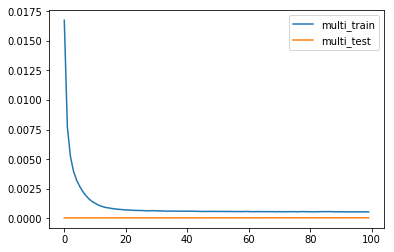

In [26]:
pyplot.plot(history.history['loss'], label='multi_train')
pyplot.plot(history.history['val_loss'], label='multi_test')
pyplot.legend()
pyplot.show()

In [49]:
#real_yhat = model.predict(real_test_X)

In [27]:
yhat = model.predict(test_X)

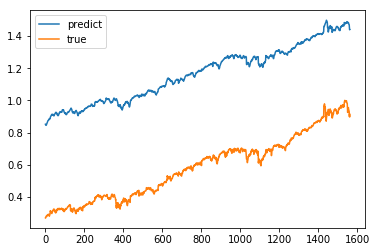

In [32]:
pyplot.plot(yhat[:,4][:,0], label='predict')
pyplot.plot(test_y[:,4][:,0], label='true')
# pyplot.plot(real_yhat[:,0][:,0], label='predict')
# pyplot.plot(real_test_y[:,0][:,0], label='true')
pyplot.legend()
pyplot.show()

In [33]:
#reshape prediction
text_X = test_X

test_X = test_X.reshape((test_X.shape[0], test_X.shape[1] * test_X.shape[2]))
yhat = yhat.reshape((yhat.shape[0],yhat.shape[1] * yhat.shape[2]))
inv_yhat = concatenate((test_X[:, :], yhat), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,-8 * time_steps:]

In [34]:
yhat.shape

(1563, 80)

In [35]:
test_y = test_y.reshape((test_y.shape[0], test_y.shape[1] * test_y.shape[2]))
inv_y = concatenate((test_X[:, :], test_y), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,-8 * time_steps:]

In [36]:
test_y.shape

(1563, 80)

In [37]:
rmse = sqrt(mean_squared_error(test_y[:,0], yhat[:,0]))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.055


In [38]:
inv_yhat[:,]

array([[1.21115016e+03, 6.71142744e+00, 5.46251878e+00, ...,
        2.71473697e+00, 1.16799727e+02, 7.41821137e-01],
       [1.20242685e+03, 6.71771898e+00, 5.47754605e+00, ...,
        2.70168215e+00, 1.17110314e+02, 7.38684105e-01],
       [1.20384172e+03, 6.67454683e+00, 5.48139587e+00, ...,
        2.68372326e+00, 1.17838980e+02, 7.34618683e-01],
       ...,
       [2.98432767e+03, 8.74546011e+00, 4.44719317e+00, ...,
        2.74080637e+00, 1.36293438e+02, 8.01053282e-01],
       [2.96941956e+03, 8.74974148e+00, 4.48494419e+00, ...,
        2.74377380e+00, 1.36320409e+02, 8.03579558e-01],
       [2.96858899e+03, 8.75988744e+00, 4.48832903e+00, ...,
        2.74107413e+00, 1.36692844e+02, 8.04930911e-01]])

In [40]:
rmse = sqrt(mean_squared_error(inv_y[:,8], inv_yhat[:,8]))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 1157.608


In [43]:
predictDates = data.tail(len(inv_y)).index
actual_chart = go.Scatter(x=predictDates, y=inv_y[:,0], name= 'Actual Price')
multi_predict_chart = go.Scatter(x=predictDates, y=inv_yhat[:,0], name= 'Multi Predict Price')
py.iplot([multi_predict_chart, actual_chart])

In [44]:
inv_y.shape

(1563, 80)